# CORA - Categorizing academic publications using getML

In this notebook, we compare getML against extant approaches in the relational learning literature on the CORA data set, which is often used for benchmarking. We demonstrate that getML outperforms the state of the art in the relational learning literature on this data set. Beyond the benchmarking aspects, this notebooks showcases getML's excellent capabilities in dealing with categorical data.

Summary:

- Prediction type: __Classification model__
- Domain: __Academia__
- Prediction target: __The category of a paper__ 
- Population size: __2708__

_Author: Dr. Patrick Urbanke_

# Background

CORA is a well-known benchmarking dataset in the academic literature on relational learning. The dataset contains 2708 scientific publications on machine learning. The papers are divided into 7 categories. The challenge is to predict the category of a paper based on the papers it cites, the papers it is cited by and keywords contained in the paper.

It has been downloaded from the [CTU Prague relational learning repository](https://relational.fit.cvut.cz/dataset/CORA) (Motl and Schulte, 2015).

### A web frontend for getML

The getML monitor is a frontend built to support your work with getML. The getML monitor displays information such as the imported data frames, trained pipelines and allows easy data and feature exploration. You can launch the getML monitor [here](http://localhost:1709).

### Where is this running?

Your getML live session is running inside a docker container on [mybinder.org](https://mybinder.org/), a service built by the Jupyter community and funded by Google Cloud, OVH, GESIS Notebooks and the Turing Institute. As it is a free service, this session will shut down after 10 minutes of inactivity.

# Analysis

Let's get started with the analysis and set up your session:

In [1]:
import copy
import os
from urllib import request

import numpy as np
import pandas as pd
from IPython.display import Image
import matplotlib.pyplot as plt
%matplotlib inline  

import getml

getml.engine.launch()
getml.engine.set_project('cora')

getML engine is already running.

Connected to project 'cora'


## 1. Loading data

### 1.1 Download from source

We begin by downloading the data from the source file:

In [2]:
conn = getml.database.connect_mariadb(
    host="relational.fit.cvut.cz",
    dbname="CORA",
    port=3306,
    user="guest",
    password="relational"
)

conn

Connection(dbname='CORA', dialect='mysql', host='relational.fit.cvut.cz', port=3306)

In [3]:
def load_if_needed(name):
    """
    Loads the data from the relational learning
    repository, if the data frame has not already
    been loaded.
    """
    if not getml.data.exists(name):
        data_frame = getml.data.DataFrame.from_db(
            name=name,
            table_name=name,
            conn=conn
        )
        data_frame.save()
    else:
        data_frame = getml.data.load_data_frame(name)
    return data_frame

In [4]:
paper = load_if_needed("paper")
cites = load_if_needed("cites")
content = load_if_needed("content")

In [5]:
paper

name,paper_id,class_label
role,unused_float,unused_string
0,35,Genetic_Algorithms
1,40,Genetic_Algorithms
2,114,Reinforcement_Learning
3,117,Reinforcement_Learning
4,128,Reinforcement_Learning
,...,...
2703,1154500,Case_Based
2704,1154520,Neural_Networks
2705,1154524,Rule_Learning


In [6]:
cites

name,cited_paper_id,citing_paper_id
role,unused_float,unused_float
0,35,887
1,35,1033
2,35,1688
3,35,1956
4,35,8865
,...,...
5424,853116,19621
5425,853116,853155
5426,853118,1140289


In [7]:
content

name,paper_id,word_cited_id
role,unused_float,unused_string
0,35,word100
1,35,word1152
2,35,word1175
3,35,word1228
4,35,word1248
,...,...
49211,1155073,word75
49212,1155073,word759
49213,1155073,word789


### 1.2 Prepare data for getML

getML requires that we define *roles* for each of the columns.

In [8]:
paper.set_role("paper_id", getml.data.roles.join_key)
paper.set_role("class_label", getml.data.roles.categorical)
paper

name,paper_id,class_label
role,join_key,categorical
0,35,Genetic_Algorithms
1,40,Genetic_Algorithms
2,114,Reinforcement_Learning
3,117,Reinforcement_Learning
4,128,Reinforcement_Learning
,...,...
2703,1154500,Case_Based
2704,1154520,Neural_Networks
2705,1154524,Rule_Learning


In [9]:
cites.set_role(["cited_paper_id", "citing_paper_id"], getml.data.roles.join_key)
cites

name,cited_paper_id,citing_paper_id
role,join_key,join_key
0,35,887
1,35,1033
2,35,1688
3,35,1956
4,35,8865
,...,...
5424,853116,19621
5425,853116,853155
5426,853118,1140289


We need to separate our data set into a training, testing and validation set:

In [10]:
content.set_role("paper_id", getml.data.roles.join_key)
content.set_role("word_cited_id", getml.data.roles.categorical)
content

name,paper_id,word_cited_id
role,join_key,categorical
0,35,word100
1,35,word1152
2,35,word1175
3,35,word1228
4,35,word1248
,...,...
49211,1155073,word75
49212,1155073,word759
49213,1155073,word789


The goal is to predict seven different labels. We generate a target column for each of those labels. We also have to separate the data set into a training and testing set.

In [11]:
data_full = getml.data.make_target_columns(paper, "class_label")
data_full

name,paper_id,class_label=Case_Based,class_label=Genetic_Algorithms,class_label=Neural_Networks,class_label=Probabilistic_Methods,class_label=Reinforcement_Learning,class_label=Rule_Learning,class_label=Theory
role,join_key,target,target,target,target,target,target,target
0,35,0,1,0,0,0,0,0
1,40,0,1,0,0,0,0,0
2,114,0,0,0,0,1,0,0
3,117,0,0,0,0,1,0,0
4,128,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...


In [12]:
split = getml.data.split.random(train=0.7, test=0.3, validation=0.0)
split

,
0,train
1,test
2,train
3,test
4,test
,...


In [13]:
container = getml.data.Container(population=data_full, split=split)
container.add(cites=cites, content=content, paper=paper)
container.freeze()
container

population
    subset   name    rows   type
0   test     paper    821   View
1   train    paper   1887   View

peripheral
    name       rows   type     
0   cites      5429   DataFrame
1   content   49216   DataFrame
2   paper      2708   DataFrame

## 2. Predictive modeling

We loaded the data and defined the roles and units. Next, we create a getML pipeline for relational learning.

### 2.1 Define relational model

To get started with relational learning, we need to specify the data model. Even though the data set itself is quite simple with only three tables and six columns in total, the resulting data model is actually quite complicated.

That is because the class label can be predicting using three different pieces of information:

- The keywords used by the paper
- The keywords used by papers it cites and by papers that cite the paper
- The class label of papers it cites and by papers that cite the paper

The main challenge here is that `cites` is used twice, once to connect the _cited_ papers and then to connect the _citing_ papers. To resolve this, we need two placeholders on `cites`.

In [14]:
dm = getml.data.DataModel(paper.to_placeholder("population"))

# We need two different placeholders for cites.
dm.add(getml.data.to_placeholder(cites=[cites]*2, content=content, paper=paper))

dm.population.join(
    dm.cites[0],
    on=('paper_id', 'cited_paper_id')
)

dm.cites[0].join(
    dm.content,
    on=('citing_paper_id', 'paper_id')
)

dm.cites[0].join(
    dm.paper,
    on=('citing_paper_id', 'paper_id'),
    relationship=getml.data.relationship.many_to_one
)

dm.population.join(
    dm.cites[1],
    on=('paper_id', 'citing_paper_id')
)

dm.cites[1].join(
    dm.content,
    on=('cited_paper_id', 'paper_id')
)

dm.cites[1].join(
    dm.paper,
    on=('cited_paper_id', 'paper_id'),
    relationship=getml.data.relationship.many_to_one
)

dm.population.join(
    dm.content,
    on='paper_id'
)

dm

,data frames,staging table
0,population,POPULATION__STAGING_TABLE_1
1,"cites, paper",CITES__STAGING_TABLE_2
2,"cites, paper",CITES__STAGING_TABLE_3
3,content,CONTENT__STAGING_TABLE_4


### 2.2 getML pipeline

<!-- #### 2.1.1  -->
__Set-up the feature learner & predictor__

We use the relboost algorithms for this problem. Because of the large number of keywords, we regularize the model a bit by requiring a minimum support for the keywords (`min_num_samples`).

In [15]:
mapping = getml.preprocessors.Mapping()

fast_prop = getml.feature_learning.FastProp(
    loss_function=getml.feature_learning.loss_functions.CrossEntropyLoss,
    num_threads=1
)

relboost = getml.feature_learning.Relboost(
    num_features=10,
    num_subfeatures=10,
    loss_function=getml.feature_learning.loss_functions.CrossEntropyLoss,
    seed=4367,
    num_threads=1,
    min_num_samples=30
)

predictor = getml.predictors.XGBoostClassifier()

__Build the pipeline__

In [16]:
pipe1 = getml.pipeline.Pipeline(
    tags=['fast_prop'],
    data_model=dm,
    preprocessors=[mapping],
    feature_learners=[fast_prop],
    predictors=[predictor]
)

pipe1

Pipeline(data_model='population',
         feature_learners=['FastProp'],
         feature_selectors=[],
         include_categorical=False,
         loss_function='CrossEntropyLoss',
         peripheral=['cites', 'content', 'paper'],
         predictors=['XGBoostClassifier'],
         preprocessors=['Mapping'],
         share_selected_features=0.5,
         tags=['fast_prop'])

In [17]:
pipe2 = getml.pipeline.Pipeline(
    tags=['relboost'],
    data_model=dm,
    feature_learners=[relboost],
    predictors=[predictor]
)

pipe2

Pipeline(data_model='population',
         feature_learners=['Relboost'],
         feature_selectors=[],
         include_categorical=False,
         loss_function='CrossEntropyLoss',
         peripheral=['cites', 'content', 'paper'],
         predictors=['XGBoostClassifier'],
         preprocessors=[],
         share_selected_features=0.5,
         tags=['relboost'])

### 2.3 Model training

In [18]:
pipe1.check(container.train)

Checking data model...
Staging... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
Preprocessing... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
Checking... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          

The pipeline check generated 3 issues labeled INFO and 0 issues labeled WARNING.


,type,label,message
0,INFO,MIGHT TAKE LONG,The number of unique entries in column 'word_cited_id' in CONTENT__STAGING_TABLE_4 is 1432. This might take a long time to fit. You should consider setting its role to unused_string or using it for comparison only (you can do the latter by setting a unit that contains 'comparison only').
1,INFO,FOREIGN KEYS NOT FOUND,"When joining POPULATION__STAGING_TABLE_1 and CITES__STAGING_TABLE_2 over 'paper_id' and 'cited_paper_id', there are no corresponding entries for 41.759406% of entries in 'paper_id' in 'POPULATION__STAGING_TABLE_1'. You might want to double-check your join keys."
2,INFO,FOREIGN KEYS NOT FOUND,"When joining POPULATION__STAGING_TABLE_1 and CITES__STAGING_TABLE_3 over 'paper_id' and 'citing_paper_id', there are no corresponding entries for 17.700053% of entries in 'paper_id' in 'POPULATION__STAGING_TABLE_1'. You might want to double-check your join keys."


In [19]:
pipe1.fit(container.train)

Checking data model...
Staging... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
Preprocessing... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          

The pipeline check generated 3 issues labeled INFO and 0 issues labeled WARNING.
To see the issues in full, run .check() on the pipeline.

Staging... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
Preprocessing... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
FastProp: Trying 3780 features... 100% |██████████| [elapsed: 00:07, remaining: 00:00]          
FastProp: Building subfeatures... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
FastProp: Building subfeatures... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
FastProp: Building features... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
XGBoost: Training as predictor... 100% |██████████| [elapsed: 00:01, remaining: 00:00]          
XGBoost: Training as predictor... 100% |███████

Pipeline(data_model='population',
         feature_learners=['FastProp'],
         feature_selectors=[],
         include_categorical=False,
         loss_function='CrossEntropyLoss',
         peripheral=['cites', 'content', 'paper'],
         predictors=['XGBoostClassifier'],
         preprocessors=['Mapping'],
         share_selected_features=0.5,
         tags=['fast_prop', 'container-NJp091'])

In [20]:
pipe2.check(container.train)

Checking data model...
Staging... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
Checking... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          

The pipeline check generated 3 issues labeled INFO and 0 issues labeled WARNING.


,type,label,message
0,INFO,MIGHT TAKE LONG,The number of unique entries in column 'word_cited_id' in CONTENT__STAGING_TABLE_4 is 1432. This might take a long time to fit. You should consider setting its role to unused_string or using it for comparison only (you can do the latter by setting a unit that contains 'comparison only').
1,INFO,FOREIGN KEYS NOT FOUND,"When joining POPULATION__STAGING_TABLE_1 and CITES__STAGING_TABLE_2 over 'paper_id' and 'cited_paper_id', there are no corresponding entries for 41.759406% of entries in 'paper_id' in 'POPULATION__STAGING_TABLE_1'. You might want to double-check your join keys."
2,INFO,FOREIGN KEYS NOT FOUND,"When joining POPULATION__STAGING_TABLE_1 and CITES__STAGING_TABLE_3 over 'paper_id' and 'citing_paper_id', there are no corresponding entries for 17.700053% of entries in 'paper_id' in 'POPULATION__STAGING_TABLE_1'. You might want to double-check your join keys."


The training process seems a bit intimidating. That is because the relboost algorithms needs to train separate models for each class label. This is due to the nature of the generated features.

In [21]:
pipe2.fit(container.train)

Checking data model...
Staging... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          

The pipeline check generated 3 issues labeled INFO and 0 issues labeled WARNING.
To see the issues in full, run .check() on the pipeline.

Staging... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
Relboost: Training subfeatures... 100% |██████████| [elapsed: 00:01, remaining: 00:00]          
Relboost: Training subfeatures... 100% |██████████| [elapsed: 00:01, remaining: 00:00]          
Relboost: Training subfeatures... 100% |██████████| [elapsed: 00:01, remaining: 00:00]          
Relboost: Training subfeatures... 100% |██████████| [elapsed: 00:01, remaining: 00:00]          
Relboost: Building subfeatures... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
Relboost: Building subfeatures... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
Relboost: Building subfeatures... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
Relboost: 

Pipeline(data_model='population',
         feature_learners=['Relboost'],
         feature_selectors=[],
         include_categorical=False,
         loss_function='CrossEntropyLoss',
         peripheral=['cites', 'content', 'paper'],
         predictors=['XGBoostClassifier'],
         preprocessors=[],
         share_selected_features=0.5,
         tags=['relboost', 'container-NJp091'])

### 2.4 Model evaluation

In [22]:
pipe1.score(container.test)

Staging... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
Preprocessing... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
FastProp: Building subfeatures... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
FastProp: Building subfeatures... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
FastProp: Building features... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          



,date time,set used,target,accuracy,auc,cross entropy
0,2023-07-30 20:02:37,train,class_label=Case_Based,0.9979,0.9999,0.02323
1,2023-07-30 20:02:37,train,class_label=Genetic_Algorithms,1.0,1.,0.004915
2,2023-07-30 20:02:37,train,class_label=Neural_Networks,0.9846,0.9983,0.065852
3,2023-07-30 20:02:37,train,class_label=Probabilistic_Methods,0.9958,0.9998,0.02765
4,2023-07-30 20:02:37,train,class_label=Reinforcement_Learning,0.9995,1.,0.009078
,...,...,...,...,...,...
9,2023-07-30 20:03:05,test,class_label=Neural_Networks,0.9513,0.9787,0.163552
10,2023-07-30 20:03:05,test,class_label=Probabilistic_Methods,0.9732,0.9872,0.083174
11,2023-07-30 20:03:05,test,class_label=Reinforcement_Learning,0.9805,0.9736,0.074599
12,2023-07-30 20:03:05,test,class_label=Rule_Learning,0.9842,0.9937,0.052146


In [23]:
pipe2.score(container.test)

Staging... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
Preprocessing... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
Relboost: Building subfeatures... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
Relboost: Building subfeatures... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
Relboost: Building subfeatures... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
Relboost: Building subfeatures... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
Relboost: Building features... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
Relboost: Building subfeatures... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
Relboost: Building subfeatures... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
Relboost: Building subfeatures... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
Relboost: Building subfeatures... 100% |██████████| [elapsed: 00:00, rema

,date time,set used,target,accuracy,auc,cross entropy
0,2023-07-30 20:03:05,train,class_label=Case_Based,1.0,1.,0.007886
1,2023-07-30 20:03:05,train,class_label=Genetic_Algorithms,1.0,1.,0.003745
2,2023-07-30 20:03:05,train,class_label=Neural_Networks,0.9926,0.9997,0.035243
3,2023-07-30 20:03:05,train,class_label=Probabilistic_Methods,0.9984,1.,0.014653
4,2023-07-30 20:03:05,train,class_label=Reinforcement_Learning,1.0,1.,0.004418
,...,...,...,...,...,...
9,2023-07-30 20:03:07,test,class_label=Neural_Networks,0.9391,0.9795,0.177732
10,2023-07-30 20:03:07,test,class_label=Probabilistic_Methods,0.9732,0.9866,0.087306
11,2023-07-30 20:03:07,test,class_label=Reinforcement_Learning,0.9805,0.977,0.079608
12,2023-07-30 20:03:07,test,class_label=Rule_Learning,0.9817,0.9922,0.065302


To make things a bit easier, we just look at our test results.

In [24]:
pipe1.scores.filter(lambda score: score.set_used == "test")

,date time,set used,target,accuracy,auc,cross entropy
0,2023-07-30 20:03:05,test,class_label=Case_Based,0.9708,0.9861,0.08689
1,2023-07-30 20:03:05,test,class_label=Genetic_Algorithms,0.9854,0.998,0.04898
2,2023-07-30 20:03:05,test,class_label=Neural_Networks,0.9513,0.9787,0.16355
3,2023-07-30 20:03:05,test,class_label=Probabilistic_Methods,0.9732,0.9872,0.08317
4,2023-07-30 20:03:05,test,class_label=Reinforcement_Learning,0.9805,0.9736,0.0746
5,2023-07-30 20:03:05,test,class_label=Rule_Learning,0.9842,0.9937,0.05215
6,2023-07-30 20:03:05,test,class_label=Theory,0.9574,0.977,0.1286


In [25]:
pipe2.scores.filter(lambda score: score.set_used == "test")

,date time,set used,target,accuracy,auc,cross entropy
0,2023-07-30 20:03:07,test,class_label=Case_Based,0.972,0.9851,0.09691
1,2023-07-30 20:03:07,test,class_label=Genetic_Algorithms,0.9927,0.9991,0.03324
2,2023-07-30 20:03:07,test,class_label=Neural_Networks,0.9391,0.9795,0.17773
3,2023-07-30 20:03:07,test,class_label=Probabilistic_Methods,0.9732,0.9866,0.08731
4,2023-07-30 20:03:07,test,class_label=Reinforcement_Learning,0.9805,0.977,0.07961
5,2023-07-30 20:03:07,test,class_label=Rule_Learning,0.9817,0.9922,0.0653
6,2023-07-30 20:03:07,test,class_label=Theory,0.9488,0.9683,0.15948


We take the average of the AUC values, which is also the value that appears in the getML monitor (http://localhost:1709/#/listpipelines/cora).

In [26]:
print(np.mean(pipe1.auc))
print(np.mean(pipe2.auc))

0.9849037843150564
0.9839762428631739


The accuracy for multiple targets can be calculated using one of two methods. The first method is to simply take the average of the pair-wise accuracy values, which is also the value that appears in the getML monitor (http://localhost:1709/#/listpipelines/cora).

In [27]:
print(np.mean(pipe1.accuracy))
print(np.mean(pipe2.accuracy))

0.9718113798503566
0.969723333913346


However, the benchmarking papers actually use a different approach: 

- They first generate probabilities for each of the labels:

In [28]:
probabilities1 = pipe1.predict(container.test)
probabilities2 = pipe2.predict(container.test)

Staging... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
Preprocessing... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
FastProp: Building subfeatures... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
FastProp: Building subfeatures... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
FastProp: Building features... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          

Staging... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
Preprocessing... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
Relboost: Building subfeatures... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
Relboost: Building subfeatures... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
Relboost: Building subfeatures... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
Relboost: Building subfeatures... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
Relboost: Build

- They then find the class label with the highest probability:

In [29]:
class_label = paper.class_label.unique()

ix_max = np.argmax(probabilities1, axis=1)
predicted_labels1 = np.asarray([class_label[ix] for ix in ix_max])

ix_max = np.argmax(probabilities2, axis=1)
predicted_labels2 = np.asarray([class_label[ix] for ix in ix_max])

- They then compare that value to the actual class label:

In [30]:
actual_labels = paper[split == "test"].class_label.to_numpy()

print("Share of accurately predicted class labels (pipe1):")
print((actual_labels == predicted_labels1).sum() / len(actual_labels))
print()
print("Share of accurately predicted class labels (pipe2):")
print((actual_labels == predicted_labels2).sum() / len(actual_labels))
print()

Share of accurately predicted class labels (pipe1):
0.8989037758830695

Share of accurately predicted class labels (pipe2):
0.8976857490864799



Since this is the method the benchmark papers use, this is the accuracy score we will report as well.

### 2.5 Studying features

__Feature correlations__

We want to analyze how the features are correlated with the target variables.

In [31]:
TARGET_NUM = 0

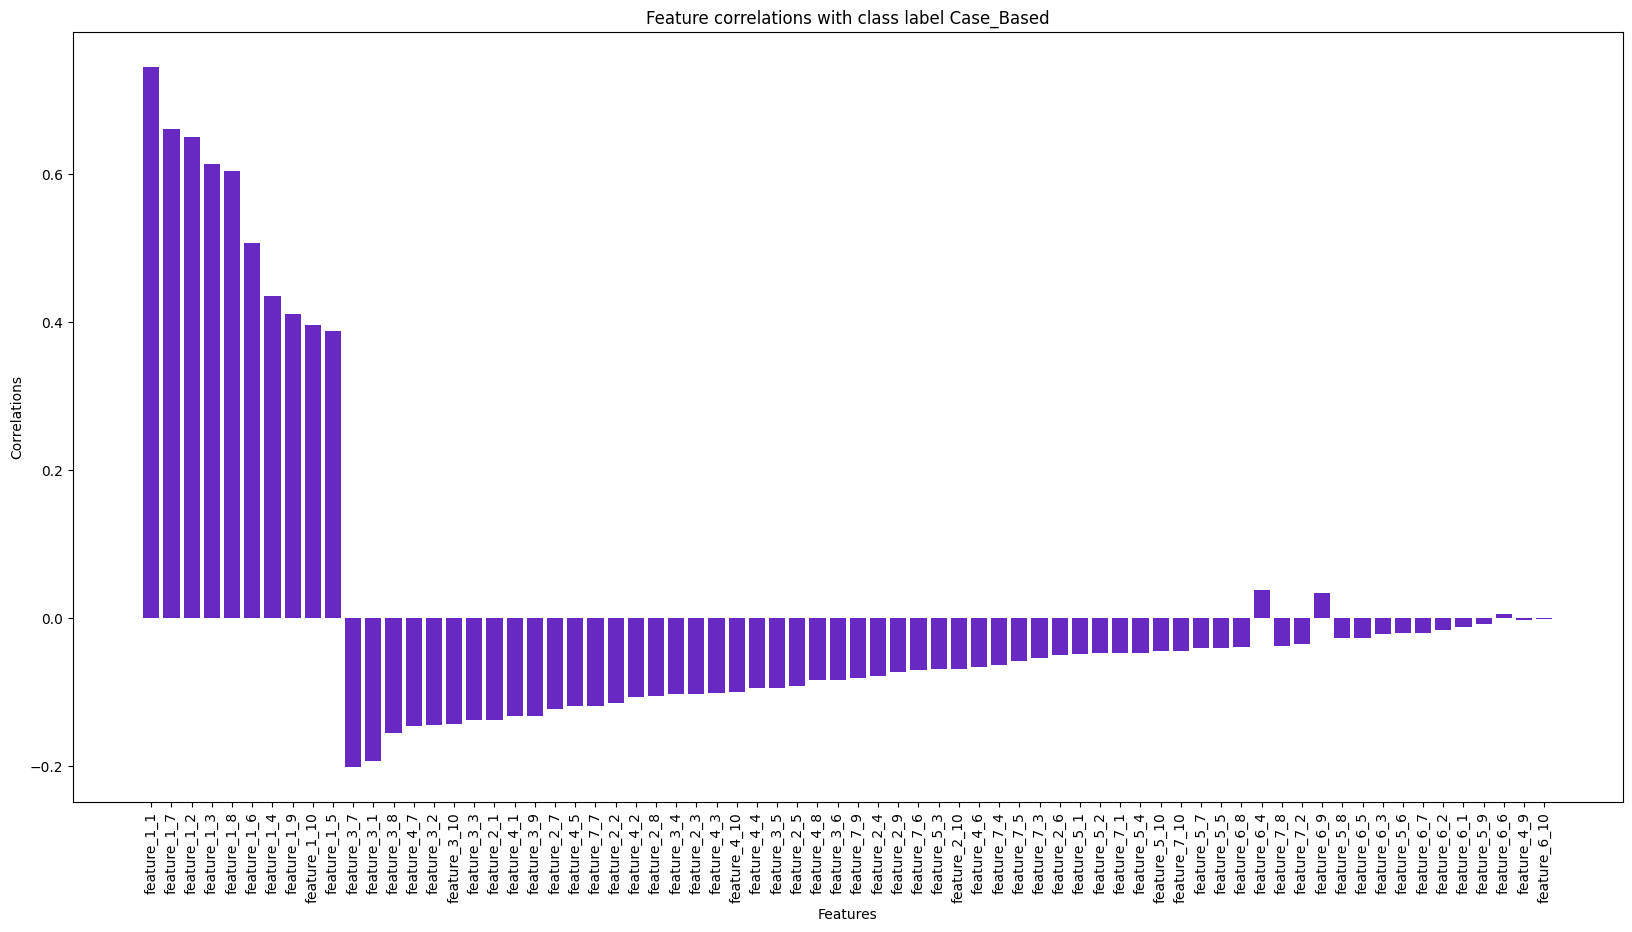

In [32]:
names, correlations = pipe2.features.correlations(target_num=TARGET_NUM)

plt.subplots(figsize=(20, 10))

plt.bar(names, correlations, color='#6829c2')

plt.title('Feature correlations with class label ' + class_label[TARGET_NUM])
plt.xlabel('Features')
plt.ylabel('Correlations')
plt.xticks(rotation='vertical')
plt.show()

__Feature importances__
 
Feature importances are calculated by analyzing the improvement in predictive accuracy on each node of the trees in the XGBoost predictor. They are then normalized, so that all importances add up to 100%.

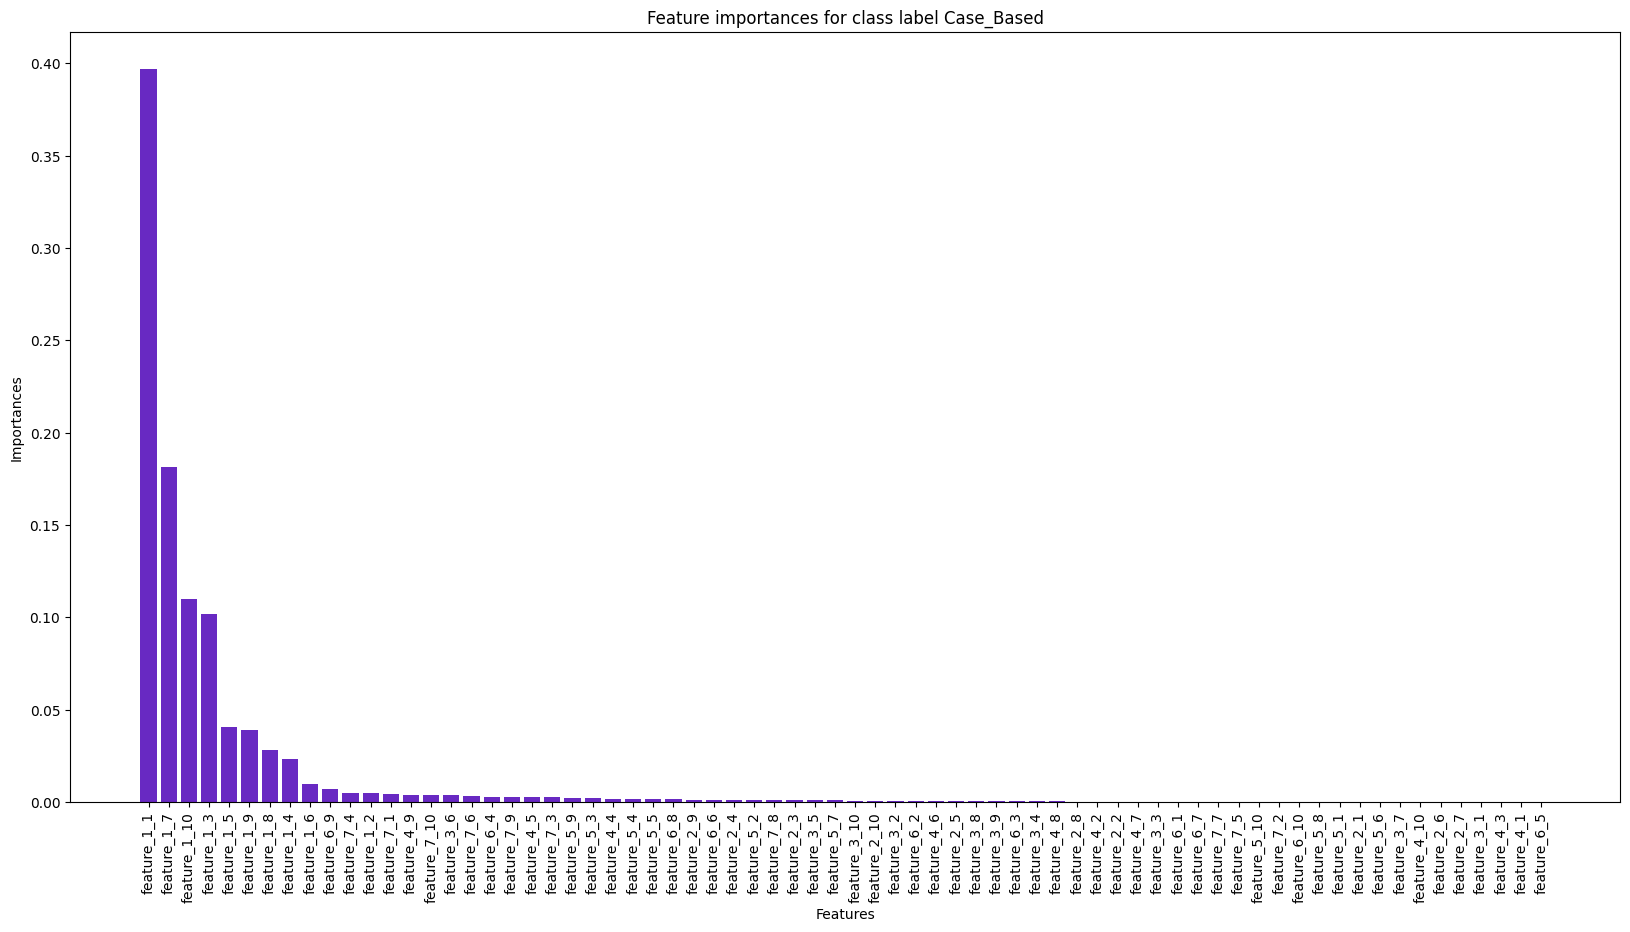

In [33]:
names, importances = pipe2.features.importances()

plt.subplots(figsize=(20, 10))

plt.bar(names, importances, color='#6829c2')

plt.title('Feature importances for class label ' + class_label[TARGET_NUM])
plt.xlabel('Features')
plt.ylabel('Importances')
plt.xticks(rotation='vertical')
plt.show()

__Column importances__

Because getML uses relational learning, we can apply the principles we used to calculate the feature importances to individual columns as well.

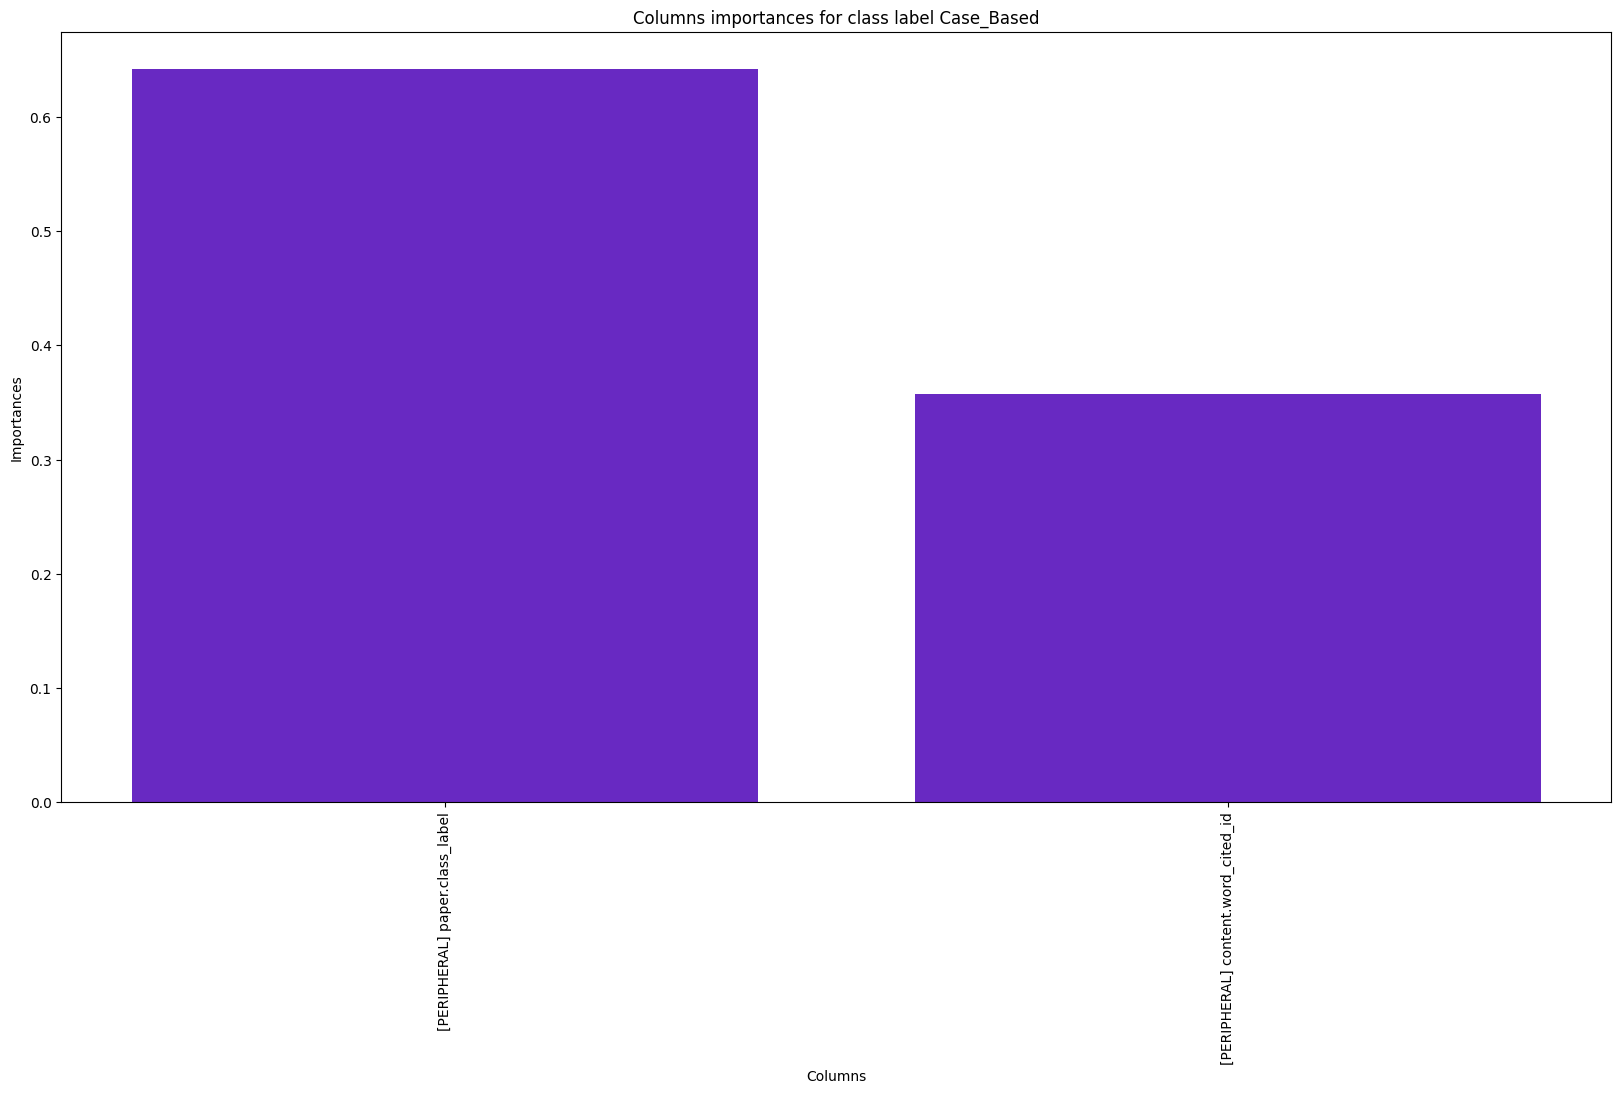

In [34]:
names, importances = pipe2.columns.importances(target_num=TARGET_NUM)

plt.subplots(figsize=(20, 10))

plt.bar(names, importances, color='#6829c2')

plt.title('Columns importances for class label ' + class_label[TARGET_NUM])
plt.xlabel('Columns')
plt.ylabel('Importances')
plt.xticks(rotation='vertical')
plt.show()

The most important features look as follows:

In [35]:
pipe1.features.to_sql()[pipe1.features.sort(by="importances")[0].name]

```sql
DROP TABLE IF EXISTS "FEATURE_1_64";

CREATE TABLE "FEATURE_1_64" AS
SELECT AVG( t2."t4__class_label__mapping_2_target_6_avg" ) AS "feature_1_64",
       t1.rowid AS rownum
FROM "POPULATION__STAGING_TABLE_1" t1
INNER JOIN "CITES__STAGING_TABLE_3" t2
ON t1."paper_id" = t2."citing_paper_id"
GROUP BY t1.rowid;
```

In [36]:
pipe2.features.to_sql()[pipe2.features.sort(by="importances")[0].name]

```sql
DROP TABLE IF EXISTS "FEATURE_6_1";

CREATE TABLE "FEATURE_6_1" AS
SELECT AVG( 
    CASE
        WHEN ( f_6_2."feature_6_2_2" > 3.142350 ) AND ( f_6_2."feature_6_2_11" > 5.518669 ) AND ( f_6_2."feature_6_2_1" > 15.824859 ) THEN 19.11484833926196
        WHEN ( f_6_2."feature_6_2_2" > 3.142350 ) AND ( f_6_2."feature_6_2_11" > 5.518669 ) AND ( f_6_2."feature_6_2_1" <= 15.824859 ) THEN 16.25336464210706
        WHEN ( f_6_2."feature_6_2_2" > 3.142350 ) AND ( f_6_2."feature_6_2_11" <= 5.518669 ) AND ( f_6_2."feature_6_2_16" > 0.759650 ) THEN 13.54988592990512
        WHEN ( f_6_2."feature_6_2_2" > 3.142350 ) AND ( f_6_2."feature_6_2_11" <= 5.518669 ) AND ( f_6_2."feature_6_2_16" <= 0.759650 ) THEN 7.015267202459228
        WHEN ( f_6_2."feature_6_2_2" <= 3.142350 ) AND ( f_6_2."feature_6_2_5" > 1.818403 ) THEN 5.178143055435354
        WHEN ( f_6_2."feature_6_2_2" <= 3.142350 ) AND ( f_6_2."feature_6_2_5" <= 1.818403 ) AND ( f_6_2."feature_6_2_13" > 0.586650 ) THEN 3.066163439590275
        WHEN ( f_6_2."feature_6_2_2" <= 3.142350 ) AND ( f_6_2."feature_6_2_5" <= 1.818403 ) AND ( f_6_2."feature_6_2_13" <= 0.586650 ) THEN -0.6748561244114177
        ELSE NULL
    END
) AS "feature_6_1",
       t1.rowid AS rownum
FROM "POPULATION__STAGING_TABLE_1" t1
INNER JOIN "CITES__STAGING_TABLE_3" t2
ON t1."paper_id" = t2."citing_paper_id"
LEFT JOIN "FEATURES_6_2" f_6_2
ON t2.rowid = f_6_2."rownum"
GROUP BY t1.rowid;
```

### 2.6 Productionization

It is possible to productionize the pipeline by transpiling the features into production-ready SQL code. Please also refer to getML's `sqlite3` and `spark` modules.

In [37]:
# Creates a folder containing the SQL code.
pipe1.features.to_sql().save("cora_pipeline")

The following files already exist in the directory (cora_pipeline):
0001_population__staging_table_1.sql
0002_cites__staging_table_2.sql
0003_cites__staging_table_3.sql
0004_content__staging_table_4.sql
0005_word_cited_id__mapping_1_1_target_1_avg.sql
0006_word_cited_id__mapping_1_1_target_2_avg.sql
0007_word_cited_id__mapping_1_1_target_3_avg.sql
0008_word_cited_id__mapping_1_1_target_4_avg.sql
0009_word_cited_id__mapping_1_1_target_5_avg.sql
0010_word_cited_id__mapping_1_1_target_6_avg.sql
0011_word_cited_id__mapping_1_1_target_7_avg.sql
0012_t3__class_label__mapping_1_target_1_avg.sql
0013_t3__class_label__mapping_1_target_2_avg.sql
0014_t3__class_label__mapping_1_target_3_avg.sql
0015_t3__class_label__mapping_1_target_4_avg.sql
0016_t3__class_label__mapping_1_target_5_avg.sql
0017_t3__class_label__mapping_1_target_6_avg.sql
0018_t3__class_label__mapping_1_target_7_avg.sql
0019_word_cited_id__mapping_2_1_target_1_avg.sql
0020_word_cited_id__mapping_2_1_target_2_avg.sql
0021_word_cit

In [38]:
pipe1.features.to_sql(dialect=getml.pipeline.dialect.spark_sql).save("cora_spark")

### 2.7 Benchmarks

State-of-the-art approaches on this data set perform as follows:

| Approach                      | Study                      | Accuracy     | AUC     |
| :--------------------------   | :------------------------  | -----------: | ------: |
| RelF                          | Dinh et al (2012)          | 85.7%        |     --  |
| LBP                           | Dinh et al (2012)          | 85.0%        |     --  |
| EPRN                          | Preisach and Thieme (2006) | 84.0%        |     --  |
| PRN                           | Preisach and Thieme (2006) | 81.0%        |     --  |
| ACORA                         | Perlich and Provost (2006) | --           |   97.0% |


As we can see, the performance of the relboost algorithm, as used in this notebook, compares favorably to these benchmarks.

| Approach                      | Accuracy     | AUC     |
| :---------------------------- | -----------: | ------: |
| FastProp                      | 89.9%        | 98.5%   |
| Relboost                      | 89.9%        | 98.3%   |


## 3. Conclusion

In this notebook we have demonstrated that getML outperforms state-of-the-art relational learning algorithms on the CORA dataset.

## References

Dinh, Quang-Thang, Christel Vrain, and Matthieu Exbrayat. "A Link-Based Method for Propositionalization." ILP (Late Breaking Papers). 2012.

Motl, Jan, and Oliver Schulte. "The CTU prague relational learning repository." arXiv preprint arXiv:1511.03086 (2015).

Perlich, Claudia, and Foster Provost. "Distribution-based aggregation for relational learning with identifier attributes." Machine Learning 62.1-2 (2006): 65-105.

Preisach, Christine, and Lars Schmidt-Thieme. "Relational ensemble classification." Sixth International Conference on Data Mining (ICDM'06). IEEE, 2006.

# Next Steps

This tutorial benchmarked getML against academic state-of-the-art algorithms from relational learning literature and getML's qualities with respect to categorical data.

If you are interested in further real-world applications of getML, head back to the [notebook overview](welcome.md) and choose one of the remaining examples.

Here is some additional material from our [documentation](https://docs.getml.com/latest/) if you want to learn more about getML:
* [Feature learning with Multirel](https://docs.getml.com/latest/user_guide/feature_engineering/feature_engineering.html#multirel)
* [Feature learning with Relboost](https://docs.getml.com/latest/user_guide/feature_engineering/feature_engineering.html#relboost)

# Get in contact

If you have any question schedule a [call with Alex](https://go.getml.com/meetings/alexander-uhlig/getml-demo), the co-founder of getML, or write us an [email](team@getml.com). Prefer a private demo of getML? Just contact us to make an appointment.